# XMM-LSS master catalogue

This notebook presents the merge of the various pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
candels = Table.read("{}/CANDELS-UDS.fits".format(TMP_DIR))           # 1.2
#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
#cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
#cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6
#servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
#swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7
#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
#sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Start with CANDELS

In [5]:
master_catalogue = candels
master_catalogue['candels_ra'].name = 'ra'
master_catalogue['candels_dec'].name = 'dec'
del candels
unused_bands = [ 'candels-megacam', 'candels-irac', 'hawki', 'suprime', 'wfc3', 'acs']
for col in master_catalogue.colnames:
    
    for band in unused_bands:
        if band in col:
            master_catalogue.remove_column(col)
            print(col, ' removed.')

f_acs_f606w  removed.
ferr_acs_f606w  removed.
f_ap_acs_f606w  removed.
ferr_ap_acs_f606w  removed.
f_acs_f814w  removed.
ferr_acs_f814w  removed.
f_ap_acs_f814w  removed.
ferr_ap_acs_f814w  removed.
f_wfc3_f125w  removed.
ferr_wfc3_f125w  removed.
f_ap_wfc3_f125w  removed.
ferr_ap_wfc3_f125w  removed.
f_wfc3_f160w  removed.
ferr_wfc3_f160w  removed.
f_ap_wfc3_f160w  removed.
ferr_ap_wfc3_f160w  removed.
f_candels-megacam_u  removed.
ferr_candels-megacam_u  removed.
f_suprime_b  removed.
ferr_suprime_b  removed.
f_suprime_v  removed.
ferr_suprime_v  removed.
f_suprime_rc  removed.
ferr_suprime_rc  removed.
f_suprime_ip  removed.
ferr_suprime_ip  removed.
f_suprime_zp  removed.
ferr_suprime_zp  removed.
f_hawki_k  removed.
ferr_hawki_y  removed.
ferr_hawki_k  removed.
f_candels-irac_i1  removed.
ferr_candels-irac_i1  removed.
f_candels-irac_i2  removed.
ferr_candels-irac_i2  removed.
f_candels-irac_i3  removed.
ferr_candels-irac_i3  removed.
f_candels-irac_i4  removed.
ferr_candels-irac

### Add DXS

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(dxs['dxs_ra'], dxs['dxs_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, dxs, "dxs_ra", "dxs_dec", radius=0.8*u.arcsec)

### Add UDS

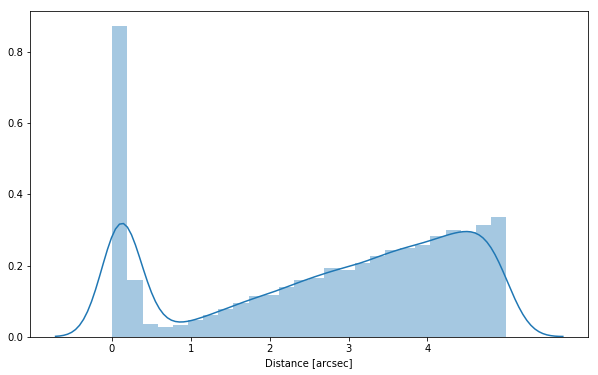

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(uds['uds_ra'], uds['uds_dec'])
)

In [9]:
# Given the graph above, we use 0.6 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, uds, "uds_ra", "uds_dec", radius=0.6*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [10]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [11]:
#Since this is not the final merged catalogue. We rename column names to make them unique
master_catalogue['ra'].name = 'ukidss_ra'
master_catalogue['dec'].name = 'ukidss_dec'
master_catalogue['flag_merged'].name = 'ukidss_flag_merged'

In [12]:
master_catalogue[:10].show_in_notebook()

idx,candels_id,ukidss_ra,ukidss_dec,candels_stellarity,f_candels-ukidss_j,ferr_candels-ukidss_j,f_candels-ukidss_h,ferr_candels-ukidss_h,f_candels-ukidss_k,ferr_candels-ukidss_k,m_candels-ukidss_j,merr_candels-ukidss_j,flag_candels-ukidss_j,m_candels-ukidss_h,merr_candels-ukidss_h,flag_candels-ukidss_h,m_candels-ukidss_k,merr_candels-ukidss_k,flag_candels-ukidss_k,candels_flag_cleaned,candels_flag_gaia,ukidss_flag_merged,dxs_id,m_ap_ukidss_j,merr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,dxs_stellarity,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,dxs_flag_cleaned,dxs_flag_gaia,uds_id,m_ap_uds_j,merr_ap_uds_j,m_uds_j,merr_uds_j,m_ap_uds_h,merr_ap_uds_h,m_uds_h,merr_uds_h,m_ap_uds_k,merr_ap_uds_k,m_uds_k,merr_uds_k,uds_stellarity,f_ap_uds_j,ferr_ap_uds_j,f_uds_j,ferr_uds_j,flag_uds_j,f_ap_uds_h,ferr_ap_uds_h,f_uds_h,ferr_uds_h,flag_uds_h,f_ap_uds_k,ferr_ap_uds_k,f_uds_k,ferr_uds_k,flag_uds_k,uds_flag_cleaned,uds_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,35489,34.4574665693,-5.12505315973,0.810000002384,-0.0070204,0.0061551,-0.0050178,0.012634,-0.0071996,0.0065574,nan,-0.951913696357,False,nan,-2.73370624794,False,nan,-0.988889186772,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
1,27199,34.3561903693,-5.27671705973,0.980000019073,0.0391383,0.0175715,0.1145652,0.0375973,0.038752,0.0205879,27.4184951054,0.487451261856,False,26.252368206,0.356310204243,False,27.4292646963,0.576822574575,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
2,72,34.4389173693,-5.27655485973,0.00999999977648,0.1376875,0.0291017,0.2253812,0.0621794,0.11561,0.0345045,26.0527637138,0.229481756223,False,25.5177057828,0.299538851378,False,26.242511497,0.324044502007,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
3,29734,34.3542499693,-5.23240925973,0.829999983311,0.0215244,0.0392939,0.0705578,0.0821216,0.1340444,0.048435,28.0676723645,1.98206732156,False,26.7786374225,1.26367877559,False,26.0818783123,0.392315032015,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
4,29795,34.5105653693,-5.23129955973,0.889999985695,-0.016015,0.0413541,0.0534729,0.0856599,0.0532227,0.0496026,nan,-2.80359934968,False,27.0796656553,1.73927456199,False,27.0847577434,1.0118866324,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
5,29791,34.4299348693,-5.23140595973,0.730000019073,0.0508796,0.0415829,0.1190635,0.0867619,0.1122186,0.0518169,27.1336407791,0.887350923137,False,26.2105533876,0.791178959325,False,26.2748378843,0.501338319569,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
6,8057,34.5051666693,-5.23047325973,0.0799999982119,0.0836337,0.0426707,0.0894166,0.0886213,0.0878248,0.0518163,26.5940467234,0.553952818928,False,26.5214546197,1.07607931774,False

## V - Adding unique identifier

In [13]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['dxs_id'].astype(str)) 
                                    +  np.char.array(master_catalogue['uds_id'].astype(str) )
                                        +  np.char.array(master_catalogue['candels_id'].astype(str) )), 
                              name="ukidss_intid"))



In [14]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['candels_id', 'dxs_id', 'uds_id', 'ukidss_intid']


## VII - Choosing between multiple values for the same filter



### VII.  UKIDSS DXS and UDS

There is no overlap between UDS and DXS. We choose the UDS fluxes over CANDELS-UDS.

In [15]:
for col in master_catalogue.colnames:
    if 'uds_h' in col:
        master_catalogue[col].name = col.replace('uds_h', 'ukidss_h')

        

has_uds_j =     ~np.isnan(master_catalogue['f_uds_j'])
has_uds_h =     ~np.isnan(master_catalogue['f_ukidss_h'])
has_uds_k =     ~np.isnan(master_catalogue['f_uds_k'])
has_ukidss_k =  ~np.isnan(master_catalogue['f_ukidss_k'])
has_ukidss_j =  ~np.isnan(master_catalogue['f_ukidss_j'])
has_candels_j =     ~np.isnan(master_catalogue['f_candels-ukidss_j'])
has_candels_h =     ~np.isnan(master_catalogue['f_candels-ukidss_h'])
has_candels_k =     ~np.isnan(master_catalogue['f_candels-ukidss_k'])

use_candels_j = has_candels_j & ~has_uds_j & ~has_ukidss_j 
use_candels_h = has_candels_h & ~has_uds_h 
use_candels_k = has_candels_k & ~has_uds_k & ~has_ukidss_k 

master_catalogue['f_ukidss_j'][has_uds_j] = master_catalogue['f_uds_j'][has_uds_j]
master_catalogue['ferr_ukidss_j'][has_uds_j] = master_catalogue['ferr_uds_j'][has_uds_j]
master_catalogue['m_ukidss_j'][has_uds_j] = master_catalogue['m_uds_j'][has_uds_j]
master_catalogue['merr_ukidss_j'][has_uds_j] = master_catalogue['merr_uds_j'][has_uds_j]
master_catalogue['flag_ukidss_j'][has_uds_j] = master_catalogue['flag_uds_j'][has_uds_j]

master_catalogue['f_ukidss_j'][use_candels_j] = master_catalogue['f_candels-ukidss_j'][use_candels_j]
master_catalogue['ferr_ukidss_j'][use_candels_j] = master_catalogue['ferr_candels-ukidss_j'][use_candels_j]
master_catalogue['m_ukidss_j'][use_candels_j] = master_catalogue['m_candels-ukidss_j'][use_candels_j]
master_catalogue['merr_ukidss_j'][use_candels_j] = master_catalogue['merr_candels-ukidss_j'][use_candels_j]
master_catalogue['flag_ukidss_j'][use_candels_j] = master_catalogue['flag_candels-ukidss_j'][use_candels_j]


master_catalogue['f_ukidss_h'][use_candels_h] = master_catalogue['f_candels-ukidss_h'][use_candels_h]
master_catalogue['ferr_ukidss_h'][use_candels_h] = master_catalogue['ferr_candels-ukidss_h'][use_candels_h]
master_catalogue['m_ukidss_h'][use_candels_h] = master_catalogue['m_candels-ukidss_h'][use_candels_h]
master_catalogue['merr_ukidss_h'][use_candels_h] = master_catalogue['merr_candels-ukidss_h'][use_candels_h]
master_catalogue['flag_ukidss_h'][use_candels_h] = master_catalogue['flag_candels-ukidss_h'][use_candels_h]


master_catalogue['f_ukidss_k'][has_uds_k] = master_catalogue['f_uds_k'][has_uds_k]
master_catalogue['ferr_ukidss_k'][has_uds_k] = master_catalogue['ferr_uds_k'][has_uds_k]
master_catalogue['m_ukidss_k'][has_uds_k] = master_catalogue['m_uds_k'][has_uds_k]
master_catalogue['merr_ukidss_k'][has_uds_k] = master_catalogue['merr_uds_k'][has_uds_k]
master_catalogue['flag_ukidss_k'][has_uds_k] = master_catalogue['flag_uds_k'][has_uds_k]

master_catalogue['f_ukidss_k'][use_candels_k] = master_catalogue['f_candels-ukidss_k'][use_candels_k]
master_catalogue['ferr_ukidss_k'][use_candels_k] = master_catalogue['ferr_candels-ukidss_k'][use_candels_k]
master_catalogue['m_ukidss_k'][use_candels_k] = master_catalogue['m_candels-ukidss_k'][use_candels_k]
master_catalogue['merr_ukidss_k'][use_candels_k] = master_catalogue['merr_candels-ukidss_k'][use_candels_k]
master_catalogue['flag_ukidss_k'][use_candels_k] = master_catalogue['flag_candels-ukidss_k'][use_candels_k]



has_ap_uds_k =  ~np.isnan(master_catalogue['f_ap_uds_k'])
has_ap_uds_j =  ~np.isnan(master_catalogue['f_ap_uds_j'])
has_ap_ukidss_k =  ~np.isnan(master_catalogue['f_ap_ukidss_k'])
has_ap_ukidss_j =  ~np.isnan(master_catalogue['f_ap_ukidss_j'])

master_catalogue['f_ap_ukidss_k'][has_ap_uds_k] = master_catalogue['f_ap_uds_k'][has_ap_uds_k]
master_catalogue['ferr_ap_ukidss_k'][has_ap_uds_k] = master_catalogue['ferr_ap_uds_k'][has_ap_uds_k]
master_catalogue['m_ap_ukidss_k'][has_ap_uds_k] = master_catalogue['m_ap_uds_k'][has_ap_uds_k]
master_catalogue['merr_ap_ukidss_k'][has_ap_uds_k] = master_catalogue['merr_ap_uds_k'][has_ap_uds_k]

master_catalogue['f_ap_ukidss_j'][has_ap_uds_j] = master_catalogue['f_ap_uds_j'][has_ap_uds_j]
master_catalogue['ferr_ap_ukidss_j'][has_ap_uds_j] = master_catalogue['ferr_ap_uds_j'][has_ap_uds_j]
master_catalogue['m_ap_ukidss_j'][has_ap_uds_j] = master_catalogue['m_ap_uds_j'][has_ap_uds_j]
master_catalogue['merr_ap_ukidss_j'][has_ap_uds_j] = master_catalogue['merr_ap_uds_j'][has_ap_uds_j]

master_catalogue.remove_columns(['f_candels-ukidss_j','ferr_candels-ukidss_j',
                                 'm_candels-ukidss_j','merr_candels-ukidss_j','flag_candels-ukidss_j',
                                 'f_candels-ukidss_h','ferr_candels-ukidss_h',
                                 'm_candels-ukidss_h','merr_candels-ukidss_h','flag_candels-ukidss_h',
                                 'f_candels-ukidss_k','ferr_candels-ukidss_k',
                                 'm_candels-ukidss_k','merr_candels-ukidss_k','flag_candels-ukidss_k',
                                 
                               'f_uds_j','ferr_uds_j','m_uds_j','merr_uds_j','flag_uds_j',
                               'f_uds_k','ferr_uds_k','m_uds_k','merr_uds_k','flag_uds_k',
                               'f_ap_uds_j','ferr_ap_uds_j','m_ap_uds_j','merr_ap_uds_j',
                               'f_ap_uds_k','ferr_ap_uds_k','m_ap_uds_k','merr_ap_uds_k'])


ukidss_origin = Table()
ukidss_origin.add_column(master_catalogue['ukidss_intid'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_uds_j] = "UDS"
origin[has_ukidss_j] = "DXS"
origin[use_candels_j] = "CANDELS"
ukidss_origin.add_column(Column(data=origin, name= 'f_ukidss_j' ))

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_uds_h] = "UDS"
origin[use_candels_h] = "CANDELS"
ukidss_origin.add_column(Column(data=origin, name= 'f_ukidss_h' ))

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_uds_k] = "UDS"
origin[has_ukidss_k] = "DXS"
origin[use_candels_k] = "CANDELS"
ukidss_origin.add_column(Column(data=origin, name= 'f_ukidss_k' ))

origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
origin_ap[has_ap_uds_k] = "UDS"
origin_ap[has_ap_ukidss_k] = "DXS"
ukidss_origin.add_column(Column(data=origin_ap, name= 'f_ap_ukidss_k' ))
origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
origin_ap[has_ap_uds_j] = "UDS"
origin_ap[has_ap_ukidss_j] = "DXS"
ukidss_origin.add_column(Column(data=origin_ap, name= 'f_ap_ukidss_j' ))

ukidss_origin.write("{}/xmm-lss_ukidss_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## IX - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any. **TODO: should we correct the astrometry with respect to Gaia positions?**

## XI - Saving the catalogue

In [16]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [17]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'candels_id', 'uds_id', 'dxs_flag_gaia', 'ukidss_flag_merged', 'candels_flag_cleaned', 'dxs_stellarity', 'dxs_id', 'uds_stellarity', 'ukidss_ra', 'ukidss_intid', 'candels_stellarity', 'uds_flag_gaia', 'dxs_flag_cleaned', 'ukidss_dec', 'candels_flag_gaia', 'uds_flag_cleaned'}


In [18]:
master_catalogue.write("{}/ukidss_merged_catalogue_xmm-lss.fits".format(TMP_DIR), overwrite = True)